## User Similarity Analysis on Simulated Ranking Data


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats
from helpers.helpers_similarity import *


In [3]:
# Define the parameters for the Gaussian distributions
mu = 0.0
sigma_u = 1.0
sigma_v = 1.0
sigma = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Define the dimensionality and number of users and items
D = 2
N = 10
M = 10

# Define the alpha values and calculate the corresponding M values
alpha_vals = [1, 3, 10, 30, 100]
M_vals = [M * alpha for alpha in alpha_vals]

# Define the number of best rankings to consider and the number of iterations
k_best = 10
nb_iter = 100


#### Compute averaged similarities for different values of M and sigma

In [5]:
# Set the seed for reproducibility
np.random.seed(0)

# Initialize an empty list to store the data
data = []

# Iterate over the sigma values, alpha values, and number of iterations
for s in sigma:
    for alpha in alpha_vals:
        for k in range(nb_iter):
            # Generate the U, V, and R matrices
            U, V, R = generate_U_V_R(mu, sigma_u, sigma_v, s, D, N, M * alpha)
            # Calculate the average similarity for all users
            similarities = sim_avg_users(U.T, R, N, k_best)

            row = [M * alpha, s, similarities]
            data.append(row)


In [6]:
df = pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
df_res = df.groupby(by=['M','sigma']).mean()
df_res['sim_U_R'].unstack()

sigma,0.0,0.2,0.4,0.6,0.8,1.0
M,,,,,,
10,0.930533,0.876622,0.814533,0.745422,0.674756,0.633333
30,0.965111,0.911644,0.870800,0.833822,0.786889,0.733867
100,0.978400,0.945778,0.905378,0.873822,0.848489,0.801778
300,0.989733,0.955289,0.915378,0.884978,0.863867,0.838756
1000,0.993600,0.961822,0.926844,0.907067,0.880267,0.859333


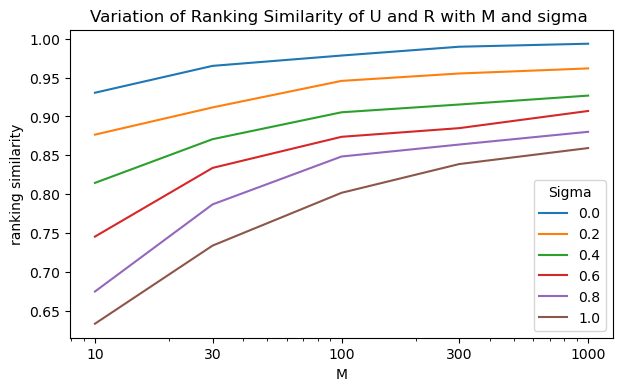

In [7]:
# Create a figure and axis with specified size
fig, ax = plt.subplots(figsize=(7,4))

# Plot the 'sim_U_R' column of the dataframe, unstacked
df_res['sim_U_R'].unstack().plot(ax=ax)

plt.legend(title='Sigma', loc='lower right')
plt.title('Variation of Ranking Similarity of U and R with M and sigma')
plt.xlabel('M')
plt.ylabel('ranking similarity')

# Set the x-axis to a logarithmic scale and specify ticks
plt.xscale('log')
plt.xticks(M_vals, M_vals)

plt.show()


# Singular Value Decomposition (SVD)

#### Compute averaged similarities for matrices U generated from SVD and ground-truth U for different values of M and sigma

In [9]:
# Set the seed for reproducibility
np.random.seed(0)

data = []

# Iterate over the sigma values, alpha values, and number of iterations
for s in sigma:
    for alpha in alpha_vals:
        for k in range(nb_iter):
            # Generate the U, V, and R matrices
            U, V, R = generate_U_V_R(mu, sigma_u, sigma_v, s, D, N, M * alpha)
            
            # Perform Singular Value Decomposition on R
            U_svd, D_svd, VT_svd = np.linalg.svd(R, full_matrices=False)
            
            # Calculate the average similarity for all users
            similarities = sim_avg_users(U.T, U_svd[:,:D], N, k_best)
            
            row = [M * alpha, s, similarities]
            data.append(row)


In [10]:
df2 = pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
df2_res = df2.groupby(by=['M','sigma']).mean()
df2_res['sim_U_R'].unstack()

sigma,0.0,0.2,0.4,0.6,0.8,1.0
M,,,,,,
10,0.925644,0.879289,0.827467,0.769378,0.666889,0.639733
30,0.921111,0.905200,0.871689,0.856578,0.811156,0.776533
100,0.926800,0.919556,0.898311,0.886622,0.875600,0.849867
300,0.924311,0.922311,0.914000,0.906622,0.894578,0.885289
1000,0.922400,0.923911,0.916356,0.911733,0.914844,0.911378


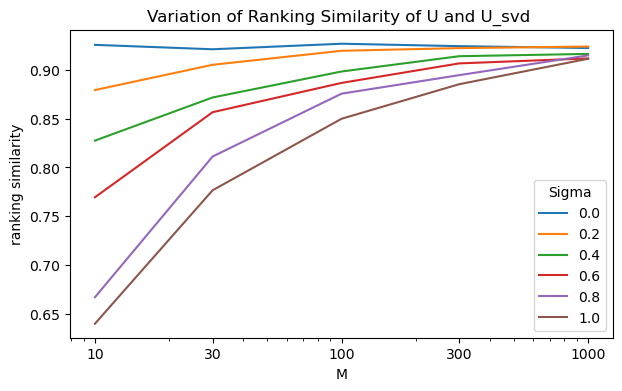

In [11]:
fig, ax = plt.subplots(figsize=(7,4))

# Plot the 'sim_U_R' column of the dataframe, unstacked
df2_res['sim_U_R'].unstack().plot(ax=ax)

plt.legend(title='Sigma', loc='lower right')
plt.title('Variation of Ranking Similarity of U and U_svd')
plt.xlabel('M')
plt.ylabel('ranking similarity')

# Set the x-axis to a logarithmic scale and specify ticks
plt.xscale('log')
plt.xticks(M_vals, M_vals)

plt.show()


In [14]:
fig.savefig('sim_U_Usvd.png')

# Truncated Singular Value Decomposition

#### Compute averaged similarities for matrices R and U obtained from truncated SVD for different values of M, sigma and singular values

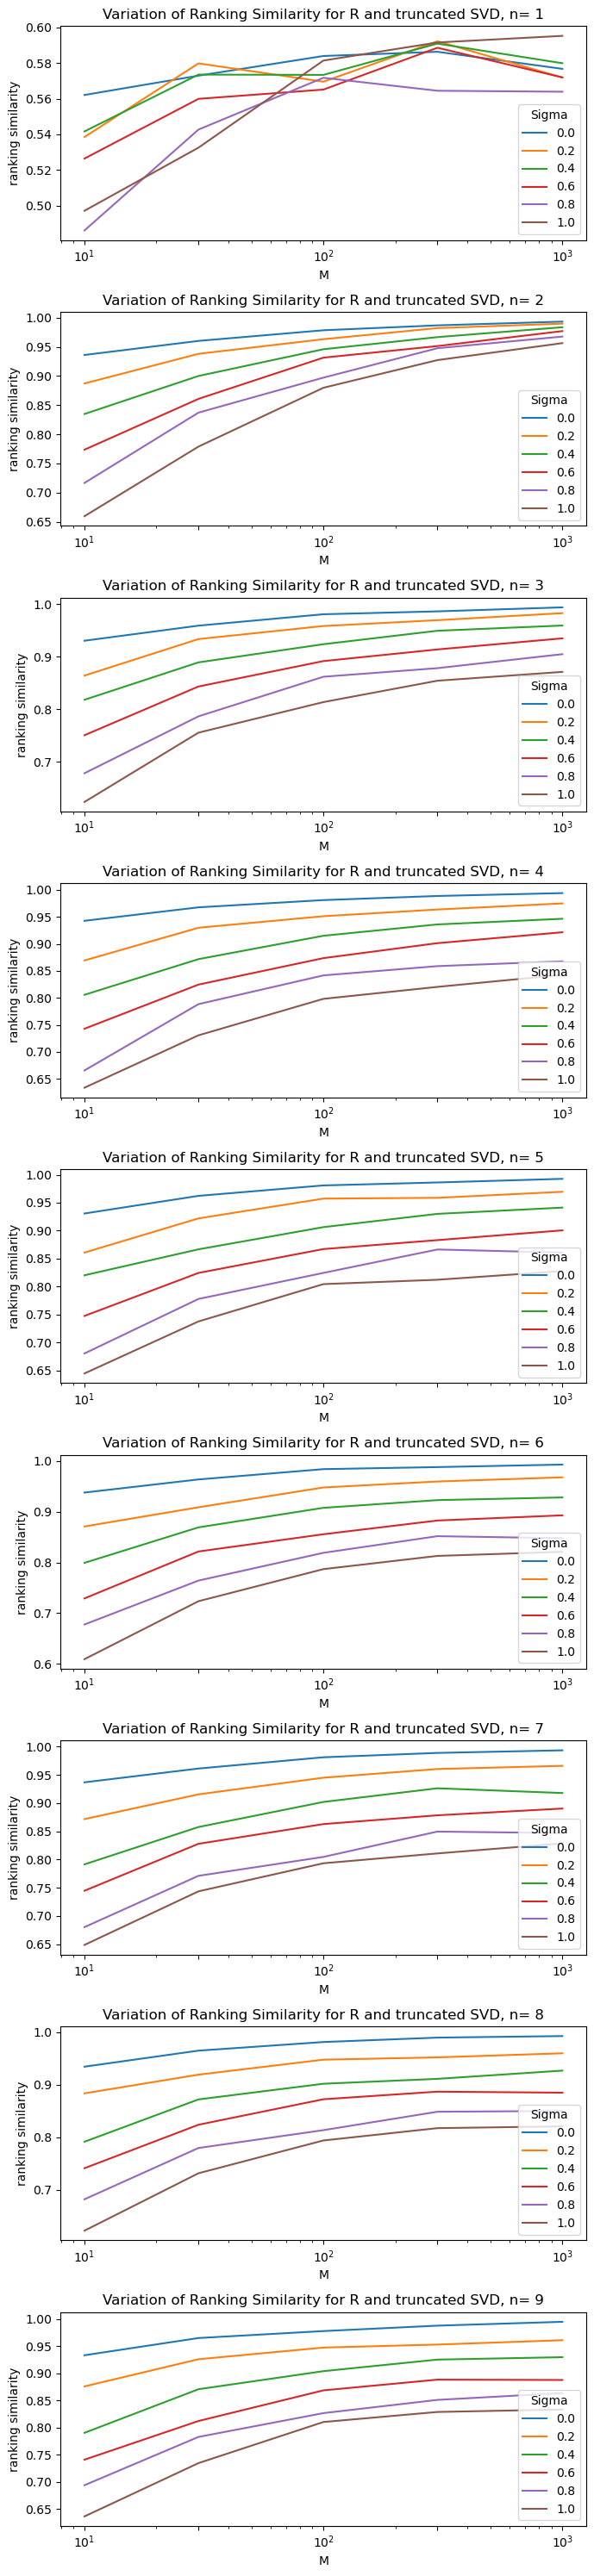

In [16]:
# Create a figure and multiple subplots
fig, axs = plt.subplots(M-1, 1, figsize=(7, 3*M))

# Iterate over the number of components for Truncated SVD
for nb_components in range(1, M, 1):
    # Initialize an empty list to store the data
    data = []

    # Iterate over the sigma values, alpha values, and number of iterations
    for s in sigma:
        for alpha in alpha_vals:
            for k in range(nb_iter):
                # Generate the U, V, and R matrices
                U, V, R = generate_U_V_R(mu, sigma_u, sigma_v, s, D, N, M*alpha)
                
                # Perform Truncated SVD on R
                trun_svd = TruncatedSVD(n_components=nb_components).fit_transform(R)
                
                # Calculate the average similarity for all users
                similarities = sim_avg_users(U.T, trun_svd, N, k_best)
                
                # Append the results to the data list
                row = [M * alpha, s, similarities]
                data.append(row)
    
    # Convert the data to a dataframe and calculate the mean for each group
    df = pd.DataFrame(data, columns=['M', 'sigma', 'sim_U_R'])
    df_res = df.groupby(by=['M', 'sigma']).mean()
    
    # Select the subplot for the current number of components
    ax = axs[nb_components-1]
    
    # Plot the 'sim_U_R' column of the dataframe, unstacked
    df_res['sim_U_R'].unstack().plot(ax=ax)
    
    ax.legend(title='Sigma', loc='lower right')
    ax.set_title('Variation of Ranking Similarity for R and truncated SVD, n= {}'.format(nb_components))
    ax.set_xlabel('M')
    ax.set_ylabel('ranking similarity')
    
    # Set the x-axis to a logarithmic scale and specify the tick locations
    ax.set_xscale('log')
    ax.set_xticks(M_vals)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
